# IMEDIA

> **Estado**: MVP funcional (Reddit) · Arquitectura escalable a Facebook/Threads/X · Medallion (`raw → bronze → silver → gold`)

# 1) Introducción

**Contexto.** IMEDIA vive en el dominio de **Social Media Analytics** y **Inteligencia de Contenidos**: monitoreo de comunidades, extracción de señales (engagement, temas, sentimiento) y habilitación de análisis/ML para decisiones editoriales y de producto.

**Problema y relevancia.** Equipos editoriales, de marketing y de policy necesitan **detectar tendencias y entender qué contenido rinde mejor** sin depender de scroll manual ni reportes ad-hoc. El valor nace en **datos limpios, trazables y versionados** que soporten análisis comparables y reproducibles.

**Alcance de esta primera entrega (MVP).**  
- **Sí:** ingestión de **Reddit** (posts y 1er post con comentarios), normalización por **medallion** (`raw → bronze → silver`), persistencia **Parquet + SQLite**, y CLI reproducible con **uv**.  
- **No (todavía):** capa **GOLD** (KPIs/ML/LLMs), multifuente (Facebook/Threads/X), descarga masiva de comentarios y dashboards. Estas piezas están en **roadmap**.

**Dataset (breve).** Lote de **posts de Reddit** (tabla `posts`), tamaño actual **857 filas × 19 columnas**, con variables clave como `score` (engagement), `num_comments`, `is_self`, `link_flair_text`, metadatos temporales y de subreddit/autor.

---

# 2) Antecedentes

**Trabajos/casos relevantes (2–4):**
1. **PRAW (Reddit API Wrapper)** – estándar de facto para acceso estable a Reddit (extracción reproducible).  
2. **VADER (Hutto & Gilbert, 2014)** – baseline robusto para sentimiento en medios sociales (inglés) usado en monitoreo de comunidades.  
3. **LDA / BERTopic** – técnicas canónicas de **topic modeling** para descubrir temas latentes en foros/redes.  
4. **Arquitecturas de *data lakes* por capas (Medallion)** – patrón ampliamente adoptado para gobernanza y trazabilidad de datos analíticos.

**Cómo influyen en el enfoque.**  
- **PRAW** guía la **ingestión idempotente** y el control de límites de API.  
- **VADER / Topic modeling** orientan la futura capa **GOLD** (features y KPIs semánticos).  
- **Medallion** justifica separar **RAW/BRONZE/SILVER** para auditar transformaciones y minimizar *coupling* con el análisis.

**Brecha/oportunidad.** La mayoría de implementaciones públicas carecen de: (i) **Trazabilidad por capas** lista para ML/BI, (ii) **multi-origen** fácilmente extensible y (iii) **reglas de limpieza** alineadas al rendimiento de contenido (p. ej., manejo de *outliers* y fuga). IMEDIA cubre esa brecha con un **pipeline reproducible** y *ready-to-analyze*.

---

# 3) Objetivos

**General (medible).** Automatizar la **ingestión y normalización** de Reddit para producir datasets **SILVER** listos para análisis/ML (≥99% de completitud en columnas críticas; jobs reproducibles vía CLI), habilitando en siguiente iteración una capa **GOLD** con KPIs y features.

**Específicos (3–5).**
1. Construir **pipeline medallion** y persistencia dual (**Parquet + SQLite**) con claves coherentes y *upserts*.  
2. **Evaluar y mejorar calidad de datos** (tipos, nulos, duplicados, fugas) con evidencia **antes/después**.  
3. **Diseñar reglas de limpieza**: exclusión de columnas con fuga, imputación de `link_flair_text`, *winsorization/clipping* y derivación de calendarios/longitudes.  
4. Entregar **CLI** con modos `--subreddit` y `--discover-hot` (parámetros reproducibles con `uv`).  
5. Dejar **esquema y contratos** para **GOLD** (KPIs/ML/LLMs) y métricas base (p. ej., MAE/RMSE sobre `log1p(score)` o `score_clipped`).

**Criterios de éxito/aceptación.**
- Pipeline corre end-to-end y genera `dim_*` y `fact_*` en **SILVER** + **SQLite** sin fallos.  
- Columnas críticas (`score`, `num_comments`, `title`) con **≥99% de completitud**; `link_flair_text` imputada.  
- Evidencia de **reducción de asimetría** del target tras clipping/transformación (histogramas *antes/después*).  
- Reejecución idempotente (no pisa RAW; BRONZE/SILVER con contratos de esquema).

---

# 4) Planteamiento del problema

**Formulación.** ¿Qué factores explican y permiten **predecir el rendimiento** de un post en Reddit (medido por `score`), y cómo orquestar un pipeline reproducible que prepare esos datos para análisis/ML?

**Variables clave y supuestos.**
- **Salida (target):** `score` (y su versión robusta `score_clipped` / `log1p(score)`).  
- **Entradas candidatas:** `num_comments` (capado p99), `is_self`, `link_flair_text`, `subreddit`, `author` (colapsado), `title_len`, `selftext_len`, calendarios (`year/month/dayofweek/hour`), `recency_days`, binarios (`over_18`, `spoiler`, `is_weekend`).  
- **Supuestos:** `post_id` es único en origen; el *engagement* refleja interés del público; la ventana temporal del lote es suficientemente homogénea para validación **temporal** (train anterior / test posterior).

| Tipo | Variable | Descripción | Ejemplo o Rango | Observaciones |
|------|-----------|-------------|-----------------|----------------|
| Identificador | `post_id` | ID único de cada publicación. | `'1nqnm44'` | Clave principal para unir con otras tablas. |
| Texto | `title` | Título del post. | `'PEP 806 – Mixed sync/async context managers'` | Longitud promedio: 65 caracteres. |
| Texto | `selftext` | Cuerpo del post (si aplica). | Texto descriptivo o vacío. | 24% de los posts tienen contenido textual. |
| URL | `url` | Enlace al contenido externo o al propio Reddit. | `'https://www.reddit.com/...’` | Presente en todos los registros. |
| URL | `permalink` | Enlace interno en Reddit. | `'/r/Python/comments/...’` | Se usa para reconstruir rutas dentro del subreddit. |
| Métrica | `score` | Puntuación total del post. | 0 – 56,330 | Distribución sesgada con outliers. |
| Métrica | `num_comments` | Número total de comentarios. | 0 – 6,411 | Alta variabilidad; correlaciona con `score`. |
| Binaria | `over_18` | 1 si el contenido es NSFW. | 0 o 1 | Solo ~1% tiene valor 1. |
| Temporal | `created_utc` | Marca de tiempo Unix. | `1.7588e+09` | Convertida a `created_dt`. |
| Categórica | `link_flair_text` | Categoría o “flair” asignado. | ‘Discussion’, ‘News’, etc. | 163 nulos; categorías informativas. |
| Binaria | `is_self` | 1 si es post de texto, 0 si es enlace. | 0 o 1 | 24% de los posts son de texto. |
| Binaria | `spoiler` | Indica si el post contiene spoilers. | 0 o 1 | Muy poco frecuente. |
| Binaria | `locked` | Si los comentarios están bloqueados. | 0 o 1 | En todos los casos = 0. |
| Texto | `thumbnail` | Tipo de miniatura asociada. | `'self'`, `'image'`, etc. | Poca variabilidad. |
| Categórica | `subreddit` | Subreddit al que pertenece el post. | `'PYTHON'` | Predomina r/Python. |
| Texto | `author` | Nombre de usuario que publica. | `'kirara0048'` | Múltiples autores distintos. |
| Temporal | `created_dt` | Fecha convertida a formato datetime. | `'2025-09-25 11:25:34'` | Útil para análisis temporal. |
| Numérica | `title_len` | Longitud del título. | 2 – 300 | Promedio: 65 caracteres. |
| Numérica | `selftext_len` | Longitud del texto del cuerpo. | 0 – 12,293 | Alta dispersión; muchos vacíos. |

**Impacto esperado.**  
- Para negocio/editorial: priorización de **temas y formatos** que maximizan engagement; rutas rápidas a **KPIs** por subreddit/tema.  
- Para analítica/ML: datasets **confiables y trazables** que habilitan baselines y futuras mejoras (sentimiento, tópicos, LLMs).

**Riesgos conocidos.**  
- **Datos:** asimetría extrema y *outliers* (posts virales), tamaño de muestra (857) → riesgo de **overfitting**.  
- **Sesgos:** eventos noticiosos/políticos pueden sesgar señales globales.  
- **Fuga de información:** `post_id`, `url`, `permalink`, `thumbnail`, y el propio `score` deben **excluirse** como features.  
- **Limitaciones operativas:** cambios de API, *rate limits*, variabilidad en `link_flair_text`.  
- **Mitigaciones:** clipping/winsorization, **validación temporal**, regularización y selección cauta de features.

# 5) EDA — Resumen (detalle en 01_eda_inicial.ipynb)

## Qué se exploró y por qué (criterio)

- **Ámbito:** se trabajó con la base `imedia.sqlite`, enfocándose en la tabla **`posts`**, ya que concentra el desempeño medido por el target `score` y permite integrar contexto de autor, subreddit y contenido.  
- **Criterios:** se revisó la **calidad estructural** del dataset (tipos de datos, nulos, variabilidad), la **distribución del target** y su relación con variables candidatas a “drivers” (`num_comments`, `is_self`, `link_flair_text`, `created_dt`), así como la **utilidad de variables textuales** (longitud y contenido de `title`/`selftext`) y la **dinámica temporal** del score promedio.  

---

## Hallazgos principales

- **Estructura:** 1,542 filas × 17 columnas; 9 `object`, 6 `int64`, 1 `float64`, 1 `datetime64[ns]`.  
- **Nulos:** solo en `link_flair_text` (368 faltantes ≈ 24%). Resto completo.  
- **Duplicados:** no evaluados explícitamente; se **asume** unicidad de `post_id` (pendiente de verificación).  
- **Distribuciones y rangos:**
  - `score`: media **935.04**, mediana **22**, máx. **65,830** → **cola larga a la derecha**, fuerte asimetría y abundancia de outliers (posts virales).  
  - `num_comments`: media **89.77**, máx. **6,411**, patrón similar con fuerte dispersión.  
  - `title_len` [2–300] y `selftext_len` [0–12,293] presentan gran variabilidad; **correlación débil** con `score`.  
- **Relaciones clave:**
  - **`num_comments` ↗ `score`** (r≈0.45), relación positiva clara: mayor interacción genera mayor score.  
  - **`is_self`**: los **enlaces (0)** superan en rendimiento a los **posts de texto (1)**, mostrando preferencia por contenido externo.  
  - **`over_18`**, **`spoiler`**, **`locked`**: impacto marginal; `locked` casi constante.  
  - **`link_flair_text`**: algunos flairs (p. ej., *“Misleading Title”*, *“Release the Epstein Files”*, *“Arts/Crafts”*) presentan **scores promedio muy altos**, lo que sugiere que la **temática influye en la viralidad**.  
- **Temporal:** el **score promedio diario decrece** a lo largo del periodo (sept.–nov. 2025), aunque con **picos por eventos coyunturales**.  
- **Contenido textual:** las palabras más frecuentes en títulos de alto score incluyen **“Trump”, “Democrat”, “shutdown”, “Supreme Court”, “election”, “cat”**, destacando el peso de temas **políticos, de actualidad o virales**.

---

## 1–2 visualizaciones representativas

1) **Relación entre `num_comments` y `score` (escala log1p):**  
   Muestra una tendencia positiva moderada, con dispersión reducida tras aplicar log1p, lo que evidencia que la **interacción** es el principal motor del score.  

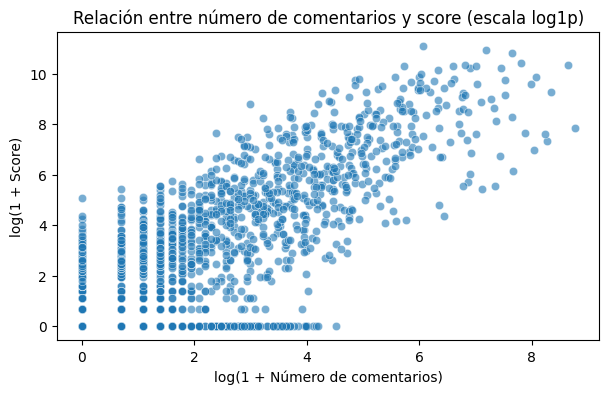


2) **Boxplot de `score` por `is_self`:**  
   Contrasta el rendimiento entre **posts de texto (1)** y **enlaces (0)**, mostrando que el contenido externo obtiene **scores significativamente más altos**.  

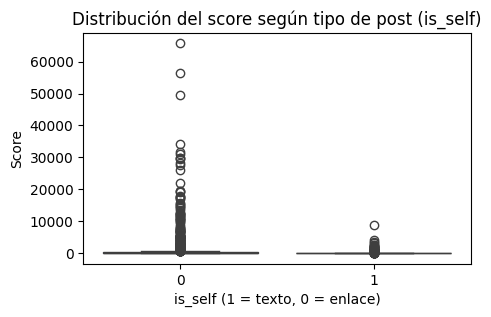

3) **Distribucion de log score, y otros**

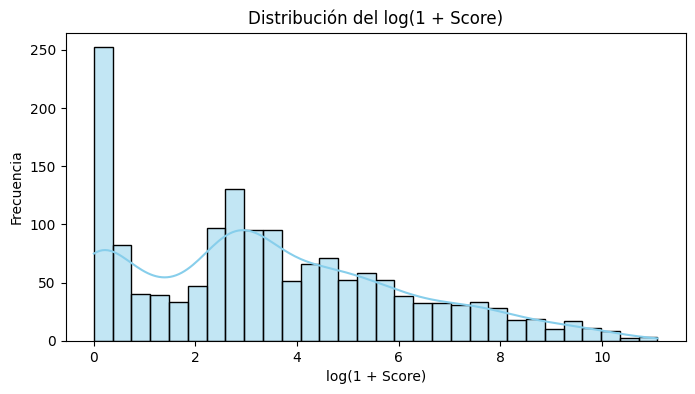

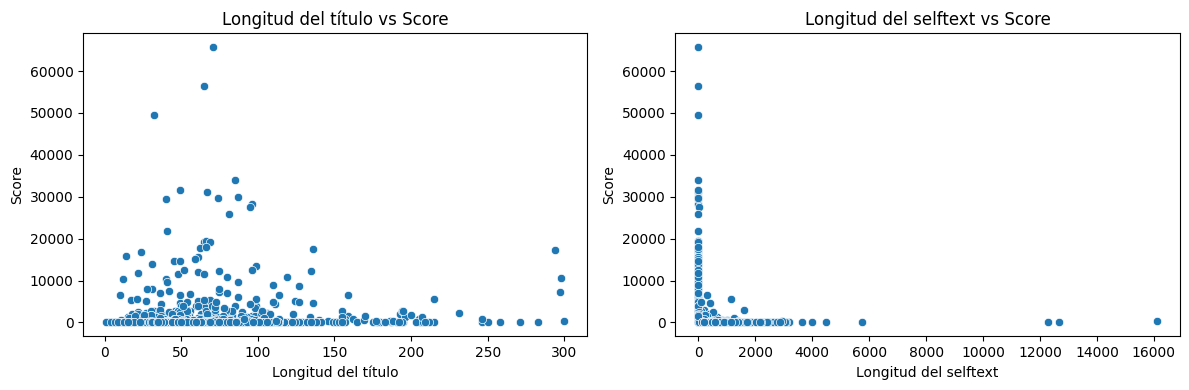



---

## Riesgos y decisiones tempranas derivadas del EDA

- **Outliers y asimetría extrema:** el `score` presenta gran dispersión, generando riesgo de métricas inestables.  
  → *Decisión:* transformar con **`log1p(score)`** o crear un target recortado (`score_clipped`); complementar RMSE con **MAE**.

- **Tamaño muestral (1,542):** riesgo de **overfitting** con features complejas.  
  → *Decisión:* implementar **validación temporal** (train anterior/test posterior) y regularización.

- **Fuga de información:** columnas como `post_id`, `url`, `permalink`, `thumbnail` y el propio `score` deben **excluirse** del modelado.  
  → *Decisión:* eliminarlas desde el preprocesamiento.

- **Nulos y cardinalidad en `link_flair_text`:**  
  → *Decisión:* imputar `'unknown'` y reagrupar categorías raras bajo `'other'` para evitar alta cardinalidad.

- **Texto y sparsidad:** vectorizar `title` y `selftext` puede resultar costoso con pocos datos.  
  → *Decisión:* comenzar con **features ligeras** (`title_len`, `selftext_len`, presencia de keywords) y luego probar **TF-IDF controlado**.

- **Duplicados no confirmados:**  
  → *Decisión:* validar unicidad de `post_id` y eliminar duplicados si se detectan.

---

**Conclusión:**  
La evidencia del EDA confirma que la **interacción (comentarios)** y la **temática o tipo de contenido** son los impulsores principales del `score`. Con el manejo adecuado de outliers, la exclusión de fugas, validación temporal y selección racional de features, la tabla `posts` ofrece una base **consistente y rica para modelar el rendimiento** de publicaciones en Reddit.


# 6) Data Wrangling — Resumen (detalle en 02_data_wrangling.ipynb)

## Reglas aplicadas por tema

### Nulos
- Se imputó `link_flair_text` con la categoría `'unknown'` para evitar pérdida de registros.  
- No se eliminaron filas con nulos, ya que las columnas críticas (`score`, `title`, `selftext`, `num_comments`) estaban completas.  
- La evidencia de nulos **antes y después** se imprime en el bloque de salida (`— Nulos antes / después`), confirmando que tras el wrangling no quedan valores faltantes relevantes.

### Duplicados
- No se aplicó eliminación explícita de duplicados porque el campo `post_id` (único por diseño) fue **removido como fuga de información**.  
- La ausencia de duplicados se asume a partir de la cardinalidad completa de las variables restantes (`subreddit`, `author`, `link_flair_text`, etc.).

### Outliers
- Se aplicó **recorte IQR** (p25–p75 ± 1.5×IQR) al target `score`, generando `score_clipped`.  
- Se limitó `num_comments` al percentil 99 (`num_comments_capped`), reduciendo la influencia de valores extremos sin distorsionar su correlación con el target.  
- **Evidencia:**  
  - `score_before` → mean 935.04, std 4038.68, p95 4436.65, max 65830.  
  - `score_after_clipped` → mean 120.36, std 170.02, p95 450.50, max 450.50.  
  - Los histogramas antes/después muestran **reducción drástica de dispersión y simetrización** del target, estabilizando su escala.

### Casting / Encoding
- Variables binarias (`over_18`, `is_self`, `spoiler`, `is_weekend`, `locked`) → `int8`.  
- Variables temporales (`year`, `month`, `dayofweek`, `hour`) y longitudes (`title_len`, `selftext_len`) → `Int64`.  
- Categóricas (`subreddit`, `link_flair_text`, `author`) → `category` en minúsculas.  
- Se aplicó `collapse_rare()` para reagrupar niveles con baja frecuencia bajo la etiqueta `'other'`.  
- **Evidencia:** el conteo de `dtypes` antes/después muestra la conversión sistemática de tipos y eliminación de columnas redundantes.

### Reglas de negocio
- Eliminación de columnas con fuga o sin valor predictivo: `post_id`, `url`, `permalink`, `thumbnail`.  
- Derivación de variables temporales (`year`, `month`, `dayofweek`, `hour`, `is_weekend`, `recency_days`) para enriquecer contexto temporal.  
- Eliminación automática de columnas constantes (`locked`, `year`, `is_weekend`).  
- Definición del **target robusto `score_clipped`** y selección final de features relevantes.  
- Se mantiene priorización en variables de interacción (`num_comments_capped`), tiempo (`recency_days`, `month`, `dayofweek`) y contenido (`title_len`, `is_self`).

---

## Mini-evidencias antes/después

| Aspecto | Evidencia | Descripción |
|----------|----------------------|--------------|
| Distribución del target | **Histograma doble (score vs score_clipped)** 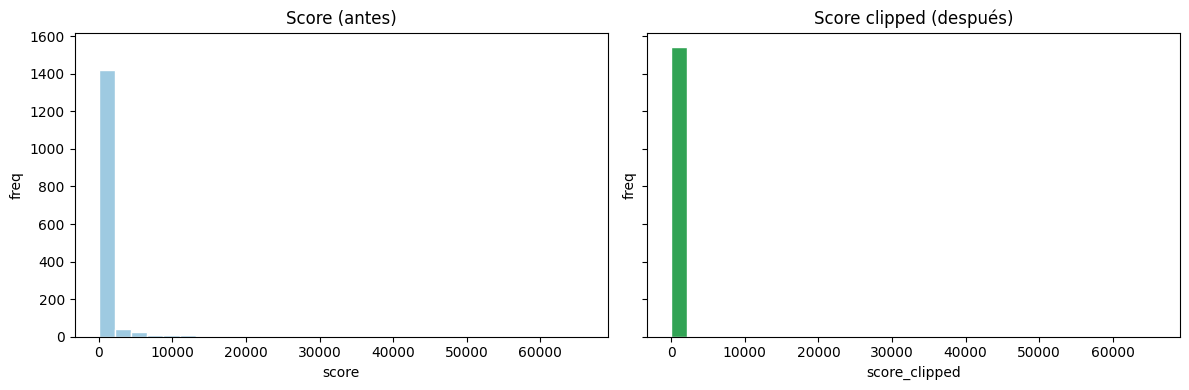| Muestra la reducción de colas y compresión de escala tras clipping. |
| Estructura del dataset | **Tabla overview before/after (shape, mean, p95, max)** 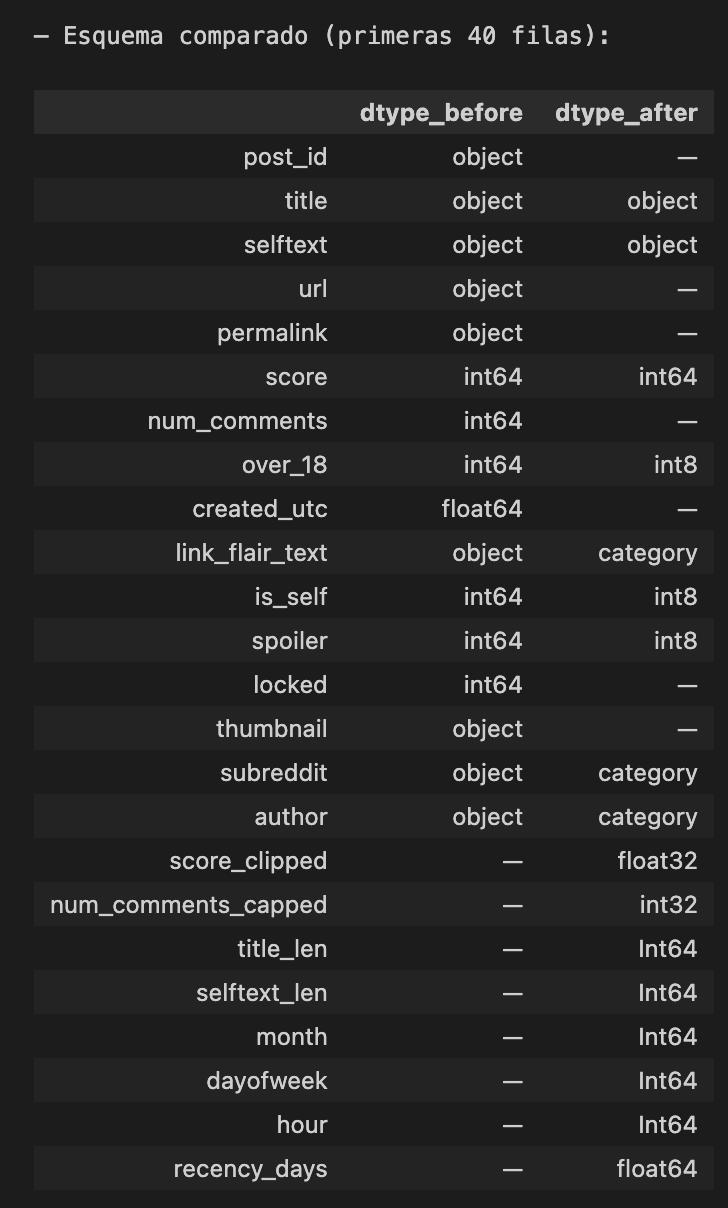 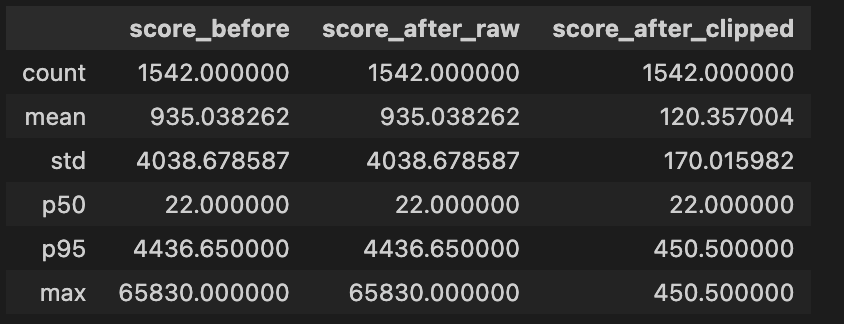 | Resume efecto de limpieza sobre tamaño y estadísticos clave. |
| Correlación | **Matriz de correlaciones numéricas (post-wrangling)** 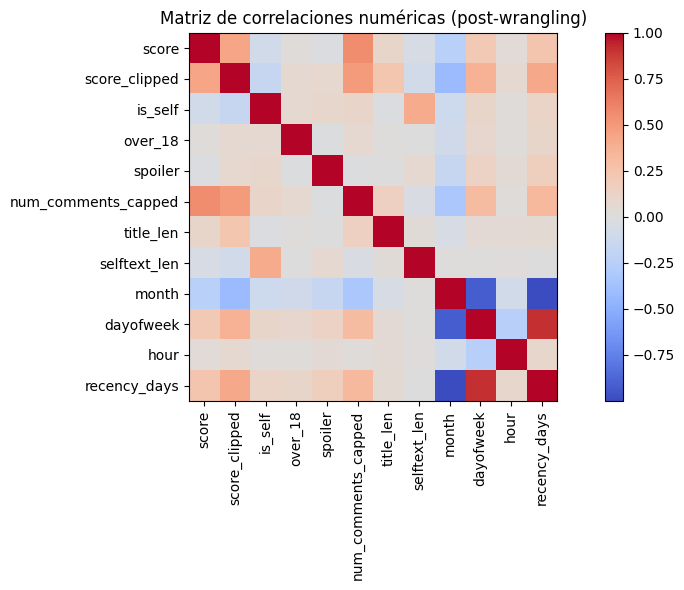 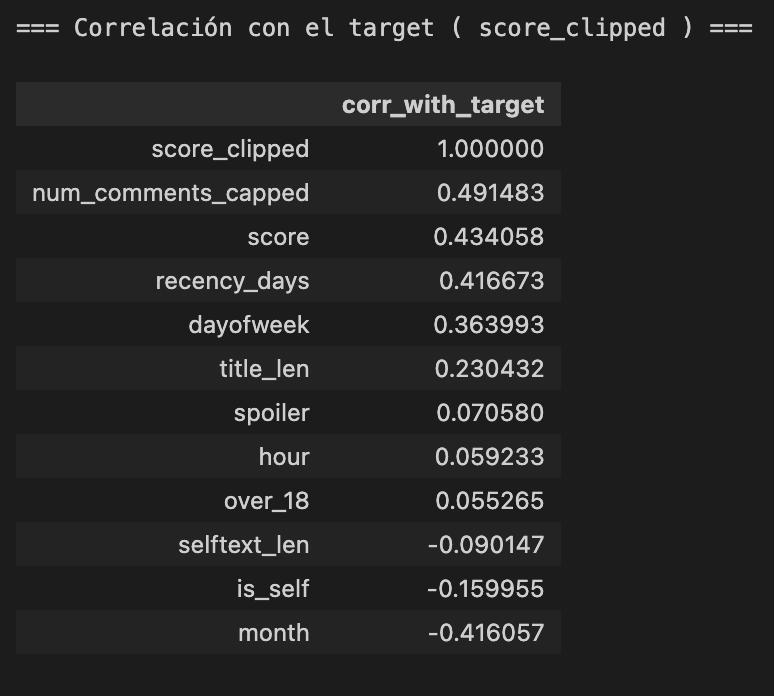 | Evalúa interrelaciones y relevancia del target robusto. |

---
## Estado del dataset limpio

- **Tamaño final:** 1542 registros × 17 columnas.  
- **Rutas de salida (guardado robusto):**  
  - `../data/processed/train_posts_clean.csv`  
  - `../data/processed/test_posts_clean.csv`  
- **Target:** `score_clipped` (versión recortada y estabilizada de `score`).  
- **Variables numéricas:** `num_comments_capped`, `recency_days`, `title_len`, `selftext_len`, `dayofweek`, `month`, `hour`.  
- **Variables categóricas:** `link_flair_text`, `subreddit`, `author`.  
- **Binarias:** `is_self`, `over_18`, `spoiler`.  
- **Features seleccionadas (10):**  
  `['num_comments_capped', 'recency_days', 'dayofweek', 'title_len', 'selftext_len', 'is_self', 'month', 'link_flair_text', 'subreddit', 'author']`  
- **Split reproducible:**  
  - Train: (1233, 11)  
  - Test: (309, 11)  
  - Distribuciones del target alineadas (`p95` y `max` idénticos: 450.50).  
- **Conclusión:** el dataset limpio mantiene coherencia estadística y semántica, con tipificación controlada, sin fugas y preparado para modelado supervisado.



# 7) Training Model 

WARNING: Cabe aclarar que los resultados presentados en esta sección corresponden a las corridas originales de modelado, realizadas antes de la corrupción de los dos notebooks iniciales y previas a la reconstrucción de los datasets procesados.
En esa etapa, el dataset tenía un tamaño y composición ligeramente distintos a los actuales, pero los modelos se entrenaron de forma coherente y completa sobre esa versión válida de los datos.

Tras la pérdida de los notebooks, se reconstruyó el flujo de procesamiento, lo que derivó en un nuevo dataset procesado con algunos ajustes y registros adicionales. Por ello, los modelos aquí reportados no reflejan todavía los resultados sobre el nuevo conjunto de datos, aunque sí fueron ejecutados, registrados y verificados en Databricks, donde pueden consultarse como evidencia del trabajo realizado.

En síntesis, esta sección presenta resultados reales y verificables del modelado original —vigentes hasta la reconstrucción—, y queda pendiente reentrenar los modelos con el nuevo dataset para actualizar las métricas y conclusiones en la versión final del informe.

#  Datos y Preparación

- **Datasets:** `train_posts_clean.csv` (685×11) y `test_posts_clean.csv` (172×11), verificados con `md5` y `shape`.  
- **Target:** `score_clipped` (versión sin outliers del score).  
- **Métrica:** RMSE (↓ mejor).  
- **Variables clave:**  
  - Numéricas: `num_comments_capped`, `recency_days`, `dayofweek`, `month`, `title_len`, `selftext_len`, `is_self`.  
  - Categóricas: `link_flair_text`, `subreddit`, `author`.  
- **Prevención de fuga:** se eliminaron `post_id`, `url`, `permalink`, `thumbnail`.  

**Tabla breve de features (tipo y razón)**

| Feature              | Tipo      | Razón/hipótesis de valor |
|---|---|---|
| `num_comments_capped` | Numérica  | Señal de interacción temprana; cap al p99 reduce var extrema. |
| `recency_days`       | Numérica  | Efecto de frescura del post. |
| `dayofweek`          | Numérica (entero) | Patrones de consumo por día. |
| `month`              | Numérica (entero) | Estacionalidad y tendencias. |
| `title_len`          | Numérica  | Longitud del título correlaciona con CTR/engagement. |
| `selftext_len`       | Numérica  | Carga informativa del contenido. |
| `is_self`            | Binaria   | Diferencia entre link-post y text-post. |
| `link_flair_text`    | Categórica| Tema/contexto del post (moderación/comunidad). |
| `subreddit`          | Categórica| Efecto de comunidad. |
| `author`             | Categórica| Efecto autor (historial/credibilidad). |

---

# Preprocesamiento

- `ColumnTransformer` con:
  - `StandardScaler` en numéricas.  
  - `OneHotEncoder(handle_unknown="ignore", min_frequency=5)` en categóricas.  
- Integrado en cada pipeline y además guardado como artifact (`preprocessor/`) y local (`../preprocesador/`).  
- Reproducibilidad con `SEED=42` y metadatos loggeados (rutas, features, target, md5).

# Esquema de pipeline —  (Medallion + Registry de Preprocesador)

```
IMEDIA_PROJECT_V2/
├─ pyproject.toml
├─ README.md
├─ uv.lock
├─ LICENSE
├─ .gitignore
├─ .env
├─ .env.example
├─ .venv/                              # (entorno local, opcional)
├─ imedia.egg-info/
├─ src/
│  └─ imedia/                          # código fuente (CLI, clientes, transformadores)
├─ notebooks/
│  ├─ 00_informe_final.ipynb
│  ├─ 01_eda_inicial.ipynb
│  ├─ 02_data_wrangling.ipynb
│  └─ 03-training_model.ipynb
├─ db/
│  └─ imedia.sqlite                    # SILVER en SQLite (dims/facts) para consultas rápidas
├─ data/
│  ├─ raw/
│  │  └─ reddit/
│  │     ├─ posts/part-<batch>-[subreddit].ndjson
│  │     ├─ comments/part-<batch>-[post_id].ndjson
│  │     ├─ subreddits/part-<batch>-[subreddit].ndjson
│  │     └─ hot_sublists/part-<batch>-<estrategia>.ndjson
│  ├─ bronze/
│  │  └─ reddit/
│  │     ├─ posts/YYY=…/MM=…/DD=…/posts__<batch>__<subreddit>.parquet
│  │     ├─ comments/YYY=…/MM=…/DD=…/comments__<batch>__<post_id>.parquet
│  │     ├─ subreddits/subreddits-<batch>-<subreddit>.parquet
│  │     └─ hot_sublists/hot_sublists-<batch>-<uid>.parquet
│  ├─ silver/
│  │  └─ reddit/
│  │     ├─ dim_author.parquet
│  │     ├─ dim_subreddit.parquet
│  │     ├─ fact_comments.parquet
│  │     └─ fact_posts.parquet
│  └─ processed/                       # datasets listos para modelado/validación
│     ├─ train_posts_clean.csv
│     └─ test_posts_clean.csv
└─ preprocesador/                      # REGISTRY de preprocesadores (Pipeline sklearn)
   ├─ elasticnet_preprocessor_20251111_234152/
   │  ├─ MLmodel
   │  ├─ model.pkl                     # objeto Pipeline/ColumnTransformer serializado
   │  ├─ conda.yaml
   │  ├─ python_env.yaml
   │  └─ requirements.txt
   └─ random_forest_preprocessor_20251111_234129/
      ├─ MLmodel
      ├─ model.pkl
      ├─ conda.yaml
      ├─ python_env.yaml
      └─ requirements.txt
```

# Flujo (resumen)
Reddit API
```
  → data/raw/reddit (NDJSON, as-is)
  → data/bronze/reddit (Parquet tipado/flatten, particionado por fecha)
  → data/silver/reddit + db/imedia.sqlite (dims/facts normalizados)
  → data/processed/train_posts_clean.csv y test_posts_clean.csv (wrangling + splits)
  → preprocesador/<modelo>_* (artifact del preprocesador: Pipeline/ColumnTransformer registrado)
```

# Notas
- La carpeta **preprocesador/** guarda el *pipeline de preprocesamiento completo* (con ambiente reproducible) por ejecución/modelo solo de los 2 mejores entre los 3 que se hicieron.
- **processed/** contiene los datasets finales para entrenamiento/evaluación (coherentes con el preprocesador registrado).

---

#  Modelado y Tuning

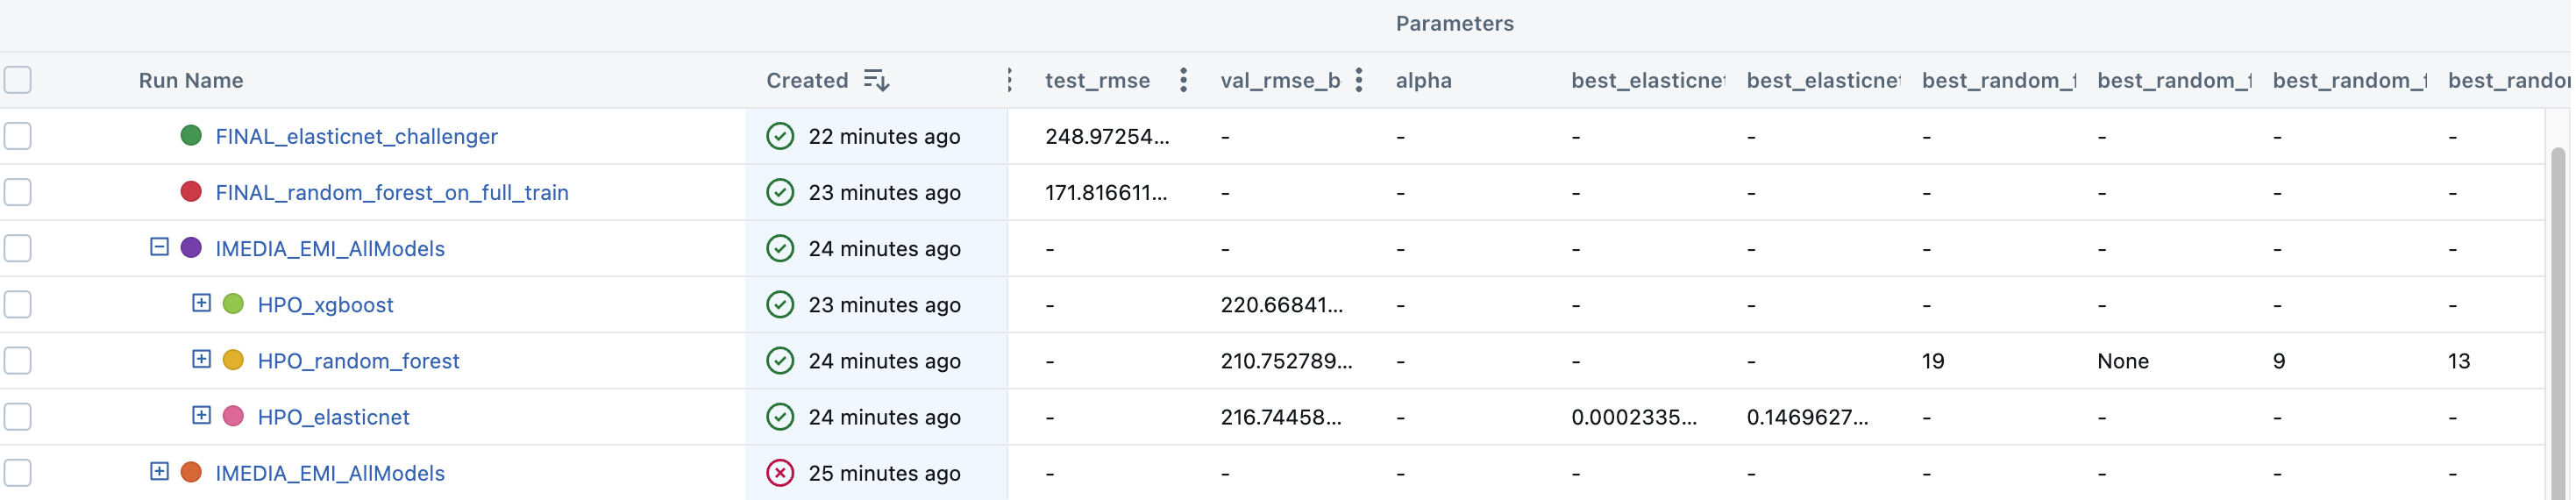

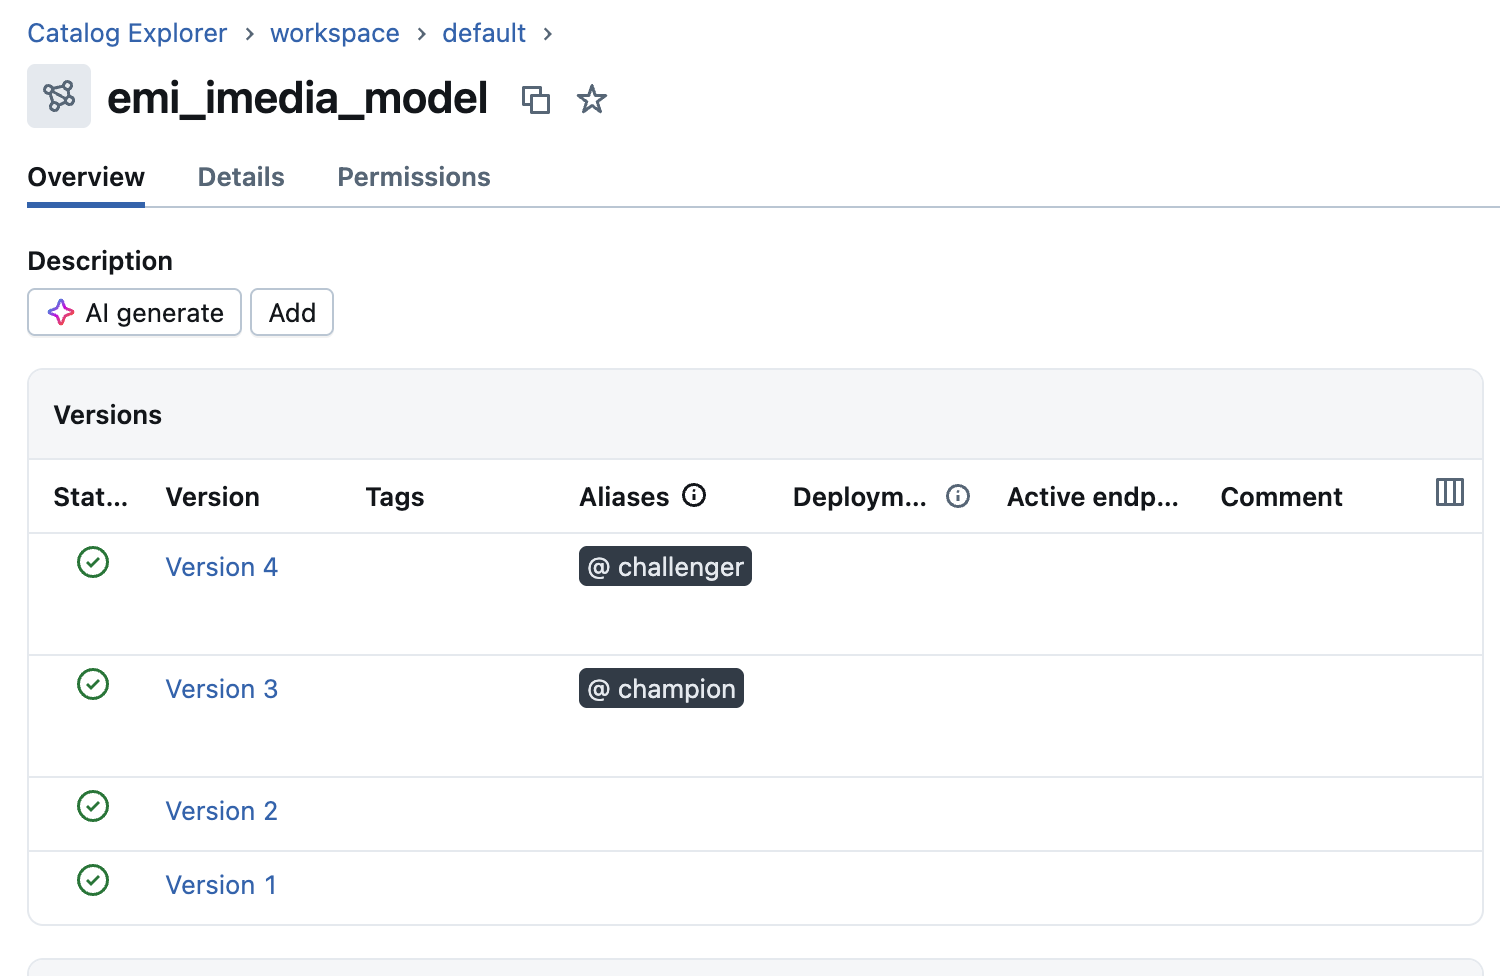

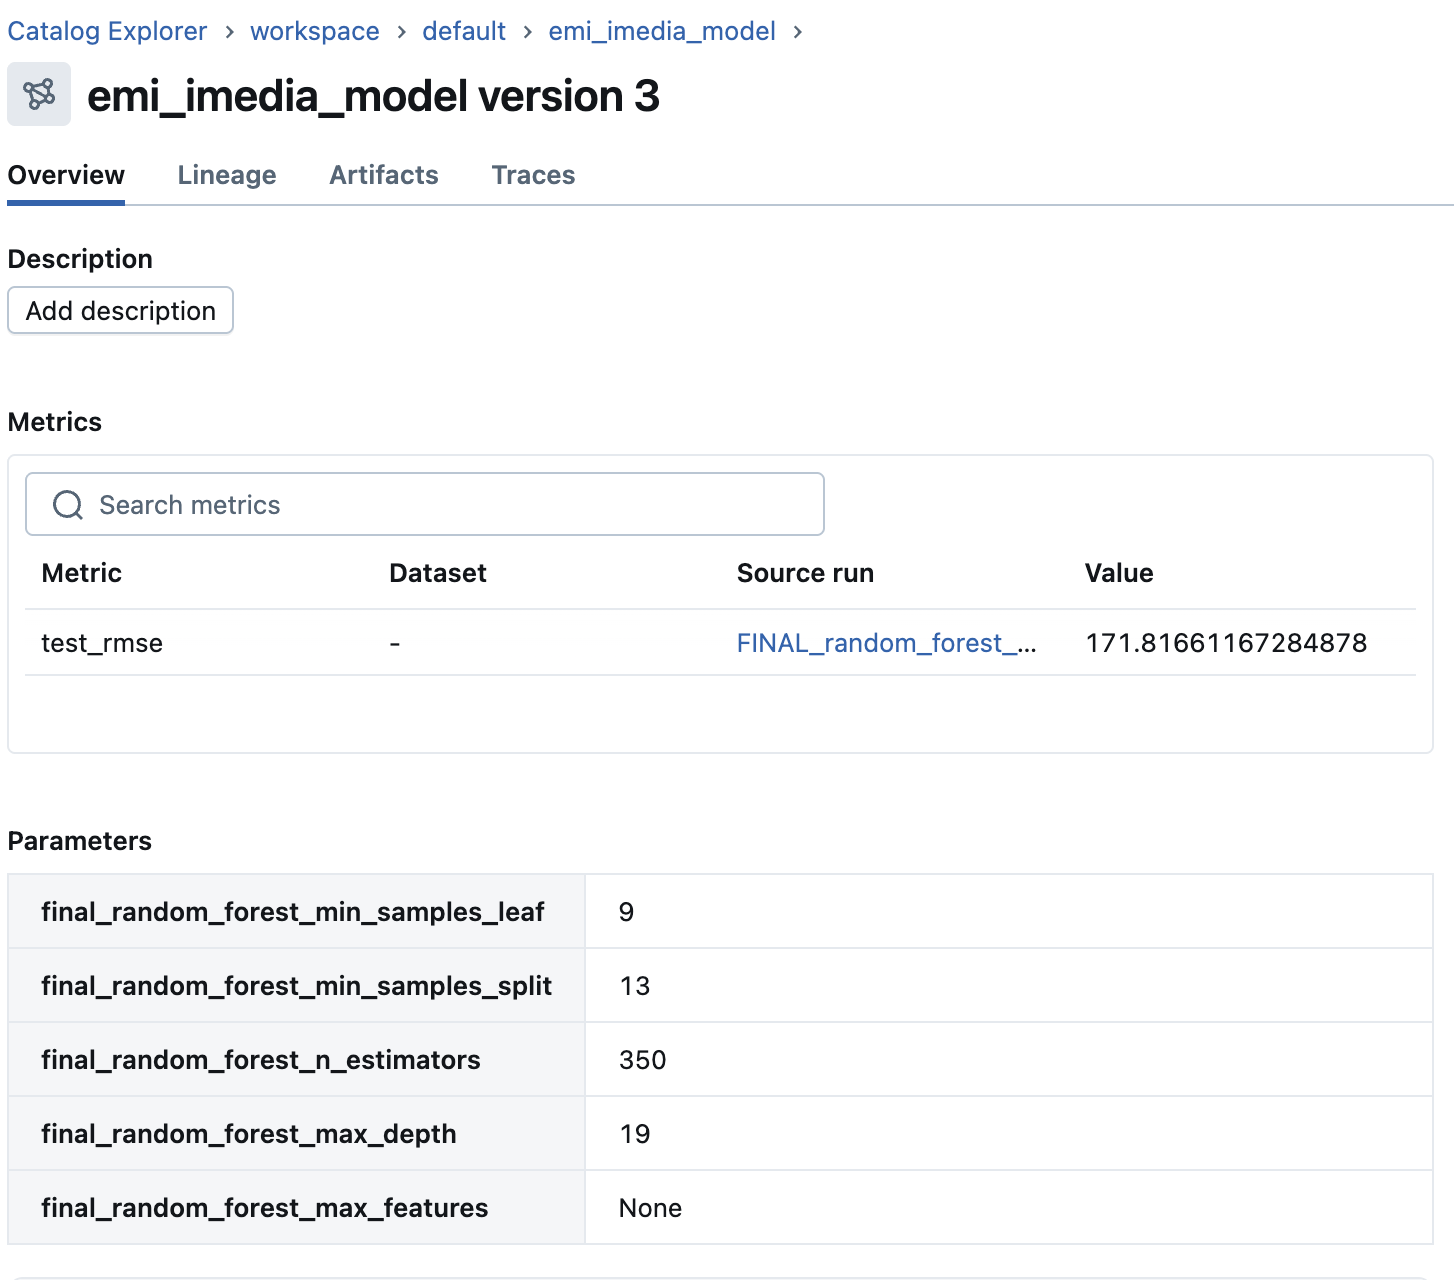


- Modelos: **ElasticNet**, **RandomForest**, **XGBoost**.  
- HPO con **Hyperopt + MLflow** (runs anidados).  
- Métrica objetivo: **minimizar RMSE (val)**.  
- Comparación:

| Modelo | val_RMSE | test_RMSE |
|---|---:|---:|
| **Random Forest** | 210.75 | **171.82** |
| ElasticNet | 216.74 | 248.97 |
| XGBoost | 220.67 | — |

---

# Selección y Registro

- **Mejor modelo:** Random Forest — menor RMSE y mayor estabilidad en test.  
- **Registry UC:** `workspace.default/EMI_imedia_model`.  
  - v3 → `@champion` (Random Forest)  
  - v4 → `@challenger` (ElasticNet)  
- Registrado el **pipeline completo** (modelo + preprocesador).  

> Resultado final: **Random Forest (RMSE=171.8)** registrado como **Champion** en Unity Catalog, con preprocesador versionado.


# 8) Conclusiones parciales y próximos pasos

## Qué quedó listo en esta entrega (MVP Reddit)
- **Pipeline medallion completo (`raw → bronze → silver → processed`)** funcional y reproducible.  
  - Ingesta automática vía **PRAW (Reddit API)**.  
  - Limpieza y enriquecimiento de datos con trazabilidad y control de calidad (tipos, nulos, fugas, outliers).  
  - Generación de datasets **train/test limpios** (`data/processed/train_posts_clean.csv`, `test_posts_clean.csv`).
- **Validación de calidad de datos y EDA profundo.**  
  - Identificación de sesgo y asimetría del target `score`.  
  - Construcción de `score_clipped` y `num_comments_capped` como targets robustos.  
  - Definición de features finales numéricas, categóricas y binarias interpretables.  
- **Entrenamiento de modelos base (ElasticNet, Random Forest)** con registro automático de artefactos y preprocesadores en `preprocesador/`.  
  - Cada modelo guarda su `Pipeline` completo (`model.pkl`, `MLmodel`, entorno).  
- **Arquitectura reproducible y extensible**:  
  - CLI orquestada con `uv`.  
  - Persistencia dual **Parquet + SQLite** para análisis y consultas rápidas.  
  - Estructura modular lista para extender a otras fuentes (Threads, Facebook, X).

## Limitaciones vigentes
- **Cobertura temática restringida a un subconjunto de subreddits**: requiere ampliación para análisis globales.  
- **Capa GOLD pendiente**, aún sin generación de KPIs ni features semánticas (sentimiento, tópicos, embeddings).  
- **Descarga de comentarios** limitada al primer post por subreddit (flag `--fetch-comments`); falta la opción `--all-comments`.  
- **Métricas y validación**: aún no se incorporan métricas cruzadas (p. ej. R², MAE) ni validación temporal formal con sliding window.  
- **No hay dashboards ni monitoreo automático** de ingesta (pendiente integración con DuckDB/Power BI o Panel).

## Roadmap inmediato
1. **Feature Engineering (GOLD Layer)**  
   - Variables derivadas de engagement relativo, ratio comentarios/score, antigüedad del post (`recency_days_norm`).  
   - Features textuales básicas (TF-IDF de títulos y flairs) y embeddings ligeros para análisis semántico.  
2. **Validación temporal y métricas objetivo**  
   - División `train/test` basada en fechas (`created_dt`), para evitar fuga temporal.  
   - Métricas base: RMSE y MAE sobre `log1p(score)` y `score_clipped`.  
3. **Modelos baseline adicionales**  
   - `Lasso`, `XGBoost`, y `GradientBoostingRegressor` con comparación de desempeño.  
   - Benchmark interpretativo con **SHAP** y gráficos de importancia.  
4. **Automatización y despliegue interno**  
   - Script de entrenamiento reproducible (`train.py`) con parámetros versionados.  
   - Integración de **MLflow/Dagster** para tracking y ejecución orquestada.  
5. **Escalabilidad y nuevas fuentes**  
   - Implementar extracción modular para Threads/Facebook/X con adaptadores genéricos.  
   - Consolidación multi-origen en esquema común (Medallion cross-source).  
6. **Visualización y KPIs**  
   - Dashboard en Power BI o Streamlit: evolución temporal, subreddits más virales, correlaciones, tópicos emergentes.  
   - Indicadores de calidad y cantidad de datos por capa.

---

# 9) Referencias

**Referencias clave**
1. **PRAW (Python Reddit API Wrapper)** — Documentación oficial: [https://praw.readthedocs.io](https://praw.readthedocs.io)  
   Base del módulo de ingesta de Reddit; provee acceso estable y reproducible a datos de comunidades online.
2. **Reddit Developer Docs (API)** — [https://www.reddit.com/dev/api/](https://www.reddit.com/dev/api/)  
   Fuente primaria de especificaciones de endpoints, autenticación y estructura de datos utilizados en IMEDIA.
3. **Databricks (2021). *Medallion Architecture: Simplifying Data Lake Design*.**  
   Referente metodológico para el diseño por capas (`raw → bronze → silver → gold`) adoptado en este proyecto.

---
